In [1]:
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
import sys
from dgl.nn import GraphConv#instead of GCNConv in PyG
import dgl
sys.path.append('..')
from model.models_dgl import GraphConvWL
from torch import nn
from build_graph import BA4labelDataset,build_graph
def generate_single_sample(label, perturb_type, nodes_num = 25, m = 1, perturb_dic = {}, 
seed = None, no_attach_init_nodes=False):
    '''
    return a networkx instance
    '''
    basis_type = "ba"
    which_type = label
    if which_type == 0:
        if perturb_type == 0:
            G, role_id, plug_id = build_graph(nodes_num, basis_type, [], start = 0, m = m, seed = seed, no_attach_init_nodes=no_attach_init_nodes)
        else:
            G, role_id, plug_id = build_graph(nodes_num - perturb_type, basis_type, [[perturb_dic[perturb_type]]], start = 0, m = m, seed = seed, no_attach_init_nodes=no_attach_init_nodes)
    else:
        list_shapes = [["house"]] * (which_type - 1) + [["five_cycle"]] * (3 - which_type)
        if perturb_type != 0:
            list_shapes = list_shapes + [[perturb_dic[perturb_type]]]
        G, role_id, plug_id = build_graph(nodes_num-10-perturb_type, basis_type, list_shapes, start = 0, m = m, seed = seed, no_attach_init_nodes=no_attach_init_nodes)
    return G
class FixedNet(nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, concat_features, conv_type, report = False):
        super(FixedNet, self).__init__()
        dim = 1
        self.report = report
        self.convs = torch.nn.ModuleList()
        if conv_type == 'GraphConvWL':#'GCNConv':
            conv_class = GraphConvWL
            #kwargs = {'add_self_loops': False}
        elif conv_type == 'GraphConv':
            conv_class = GraphConv
            kwargs = {}
        else:
            raise RuntimeError(f"conv_type {conv_type} not supported")

        self.convs.append(conv_class(num_node_features, dim, bias = True))#, **kwargs))
        for i in range(num_layers - 1):
            self.convs.append(conv_class(dim, dim, bias = True))#, **kwargs))
        self.concat_features = concat_features


    def forward(self, g, x):
        '''
        g: DGL Graph
        x: node feature
        '''
        xs = [x]
        for conv in self.convs:
            x = conv(g, x)
            x = F.relu(x)
            xs.append(x)
        if self.concat_features:
            x = torch.cat(xs, dim=1)
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        if self.report == True:
            return hg, xs
        return hg
    
    def use_report(self):
        self.report = True

    def unuse_report(self):
        self.report = False

def test_model_fixed(model_test, graphs_num = 1000, m = 5, nodes_num = 25, perturb_dic = {}, device = torch.device('cuda'), no_attach_init_nodes = False):
    model_test.eval()
    data = BA4labelDataset(graphs_num=graphs_num, m = m, nodes_num=nodes_num, perturb_dic = perturb_dic, no_attach_init_nodes = no_attach_init_nodes)
    testdataloader = dgl.dataloading.GraphDataLoader(data, batch_size = 16, shuffle = True)
    correct = 0
    total = 0
    for g, labels in testdataloader:
        g = g.to(device)
        output = model_test(g, g.ndata['x'])
        pred = []
        for one_output in output:
            if one_output == 0:
                pred.append(0)
            elif one_output == 20/nodes_num:
                pred.append(1)
            elif one_output == 14/nodes_num:
                pred.append(2)
            else:#8/nodes_num
                pred.append(3)
        pred = torch.tensor(pred)
        eq_pred = pred.eq(labels)
        correct += eq_pred.sum().item()
        if eq_pred.sum().item() != 16:
            return g,eq_pred,labels
        total += len(labels.to(device))
    test_acc = correct/total
    return test_acc
model_fixed = FixedNet(1, 4, 2, False, 'GraphConvWL')
k = 0
'''for p in model_fixed.parameters():
    if k == 0 or k == 2 or k == 5 or k == 8 or k == 9:
        torch.nn.init.constant_(p, -1)
    elif k == 1:
        torch.nn.init.constant_(p, 4)
    elif k == 4 or k == 7 or k == 10:
        torch.nn.init.constant_(p, 2)
    elif k == 3 or k == 6 or k == 11:
        torch.nn.init.constant_(p, 0)
    else:
        torch.nn.init.constant_(p, 1)
    k += 1'''
for p in model_fixed.parameters():
    if k == 0 or k == 2:
        torch.nn.init.constant_(p, 1)
    elif k == 3:
        torch.nn.init.constant_(p, -1)
    elif k == 5:
        torch.nn.init.constant_(p, 3)
    else:
        torch.nn.init.constant_(p, 0)
    k += 1

Using backend: pytorch


tensor([[0.3200]], device='cuda:0', grad_fn=<DivBackward0>)


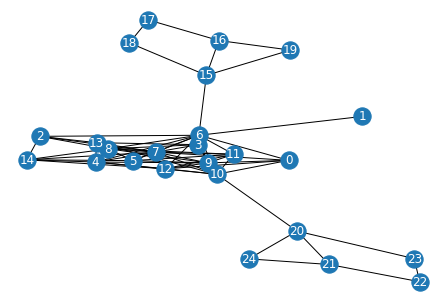

In [2]:
device = torch.device('cuda')
model_fixed = model_fixed.to(device)
model_fixed.unuse_report()
G = generate_single_sample(3, 0, nodes_num = 25, m = 6, perturb_dic = {4:'square_diagonal'}, seed = 0, no_attach_init_nodes = True)
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos, with_labels = True, font_color = 'white')
g = dgl.from_networkx(G)
g = g.to(device)
output = model_fixed(g, torch.ones((25,1)).to(device))
print(output)

In [77]:
test_model_fixed(model_fixed,graphs_num = 1000000, m = 6, nodes_num = 50, no_attach_init_nodes = True)

1.0

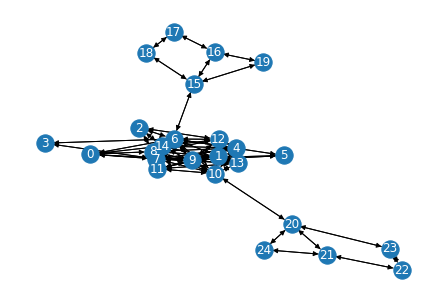

In [53]:
G = dgl.to_networkx(g.cpu())
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos, with_labels = True, font_color = 'white')

In [24]:
import numpy as np
def get_accuracy(g, correct_ids, edge_mask):
    '''
    edge_index: 2 elements tuple, u and v
    '''
    if correct_ids == []:
        if np.max(edge_mask)!=0 or np.all(np.mean(edge_mask) == edge_mask):
            return 1
        else:
            return 0
    else:
        correct_count = 0
        correct_edges = set()
        for i in range(g.num_edges()):
            u = g.edges()[0][i].item()
            v = g.edges()[1][i].item()
            if u in correct_ids or v in correct_ids:
                correct_edges.add((u,v))
                correct_edges.add((v,u))
        print(correct_edges)
        for x in np.argsort(-edge_mask)[:len(correct_edges)]:
            u = g.edges()[0][x].item()
            v = g.edges()[1][x].item()
            if (u, v) in correct_edges:
                correct_count += 1
        return correct_count / len(correct_edges)

In [41]:
get_accuracy(g, list(range(15,25)), np.random.uniform(size = g.num_edges()))

{(18, 17), (6, 15), (20, 23), (21, 22), (22, 23), (23, 22), (17, 18), (19, 15), (16, 19), (24, 20), (20, 10), (21, 24), (10, 20), (15, 16), (16, 15), (15, 19), (18, 15), (20, 21), (21, 20), (20, 24), (22, 21), (23, 20), (17, 16), (19, 16), (15, 6), (24, 21), (15, 18), (16, 17)}


0.14285714285714285